In [2]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from time import time
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import random
import h5py

In [3]:
environment = gym.make("CartPole-v1", render_mode="human")
observation, info = environment.reset()

for _ in range(1000):
    action = environment.action_space.sample()  # Random action
    observation, reward, terminated, truncated, info = environment.step(action)

    if terminated or truncated:
        observation, info = environment.reset()

environment.close()

In [4]:
# create the DQN, with the input being a list of states (numpy arrays)
# we parameterize based on a sepcified sequence length

class Net(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.fc1 = nn.Linear(4 * seq_len, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
# create a preprocessing function

def preprocess(s):
    
    # turn sequence of states into one array

    s = np.concatenate(s) 

    # turn array to tensor

    s = torch.tensor(s, dtype=torch.float32)
    
    return s

In [6]:
# create Deep Q-Learning Function

def deep_Q_learning(sequence_length, init_epsilon, M, G, min_epsilon, decay, T, N, batch_size, gamma, C, epsiode_seeds):

    # initialize replay memory, Q, Q hat and the initial epsilon

    D = []
    Q = Net(sequence_length)
    Q_hat = Net(sequence_length)
    epsilon = init_epsilon

    # set the environment

    environment = gym.make("CartPole-v1", render_mode="rgb_array")

    # denote the loss function and optimizer

    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(Q.parameters(), alpha=0.95, lr=0.00025)

    # create lists to store total rewards for the episode and the epsilon value

    REWARDS = []
    DECAY = [epsilon]

    # set a step count for global number of steps

    step_count = 1

    # iterate for M episode

    for episode in range(M):

        # adjust epsilon after G epsiodes (with minimum of min_epsilon)

        if episode > G:
            epsilon = max(min_epsilon, decay * epsilon)
            DECAY.append(epsilon)
        
        elif episode > 0:
            DECAY.append(epsilon)
        
        # initialize total reward

        total_reward = 0
        
        # reset the environment, intialize the sequence and preprocessed sequence

        x, _ = environment.reset()

        s = [x for _ in range(sequence_length)]
        phi = preprocess(s)

        # initialize the termination term as False
        # we will run every epsiode until termination

        terminated = False

        # iterate for (at most) T steps

        for t in range(T):

            # if the episode is done, end it
            
            if terminated:
                break

            # with probabilty epsilon, select a random action

            if random.random() < epsilon:
                a = environment.action_space.sample()
            
            # otherwise, pick the action with the best Q-value

            else:
                a = torch.argmax(Q(phi)).item()
            
            # take a step

            x_prime, r, terminated, _, _ = environment.step(a)

            # add termination penalty (if terminated) and adjust total reward

            if terminated:
                r -= 1

            total_reward += r

            # create new sequences

            s_prime = s.copy()
            s_prime.pop(0)
            s_prime.append(x_prime)
            phi_prime = preprocess(s_prime)

            # get the episode-not-ended status as a binary variable

            if terminated:
                status = 0
            
            else:
                status = 1

            # store the transition in D (and remove a transition if needed)
            # for y_j, we add the status

            D.append((phi, a, r, phi_prime, status))

            if len(D) >= N:
                D.pop(0)
            
            # only perform gradient descent once we have enough for a full batch

            if len(D) >= batch_size and episode > 100:

                # get a minibatch from D

                batch = random.sample(D, batch_size)

                # get components of D as batches

                PHI = torch.stack([datapoint[0] for datapoint in batch])
                A = torch.tensor([datapoint[1] for datapoint in batch], dtype=torch.long)
                R = torch.tensor([datapoint[2] for datapoint in batch], dtype=torch.float32)
                PHI_PRIME = torch.stack([datapoint[3] for datapoint in batch])
                STATUS = torch.tensor([datapoint[4] for datapoint in batch], dtype=torch.float32)

                # get Q-values for Q under PHI and get predicitons

                Q_values = Q(PHI)
                predictions = Q_values.gather(1, A.unsqueeze(1)).view(-1)

                # get the maximum of the Q_hat values under PHI_PRIME, and calculate y_j (targets)

                Q_hat_values = Q_hat(PHI_PRIME).detach()
                max_Q_hat = torch.max(Q_hat_values, dim = 1).values.detach()
                targets = R + gamma * max_Q_hat * STATUS
                targets[STATUS == 0] = R[STATUS == 0]

                # get loss and update

                loss = criterion(predictions, targets)
                optimizer.zero_grad()
                torch.nn.utils.clip_grad_norm_(Q.parameters(), max_norm=1.0)
                loss.backward()
                optimizer.step()
            
            # adjust parameters of Q_hat every C epsiodes

            step_count += 1 

            if step_count % C == 0:
                Q_hat.load_state_dict(Q.state_dict())
            
        # add total reward to REWARD

        REWARDS.append(total_reward)

    # return the model weights
     
    return Q.state_dict(), REWARDS, DECAY

Untrained Total Rewards averaged out to 9.44 with a standard deviation of 0.782639925205233
Training took 3.4809791525204976 minutes
Trained Total Rewards averaged out to 294.54 with a standard deviation of 14.276080156908082


Text(0.5, 1.0, 'Epsilon Decay per Episode')

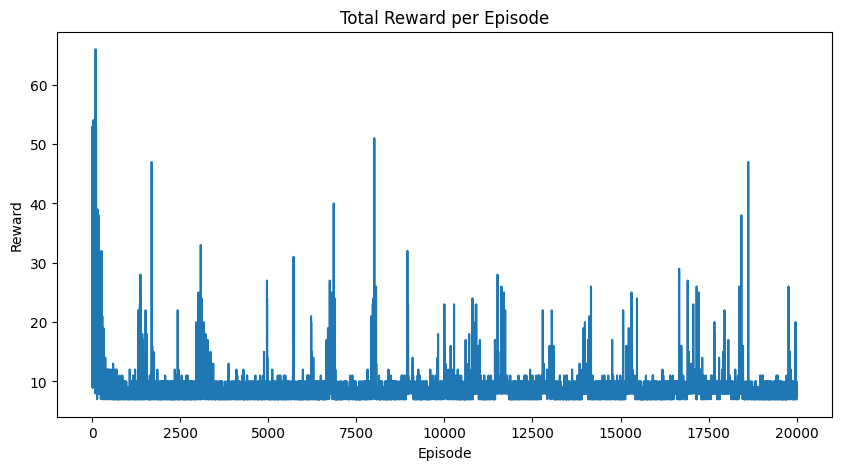

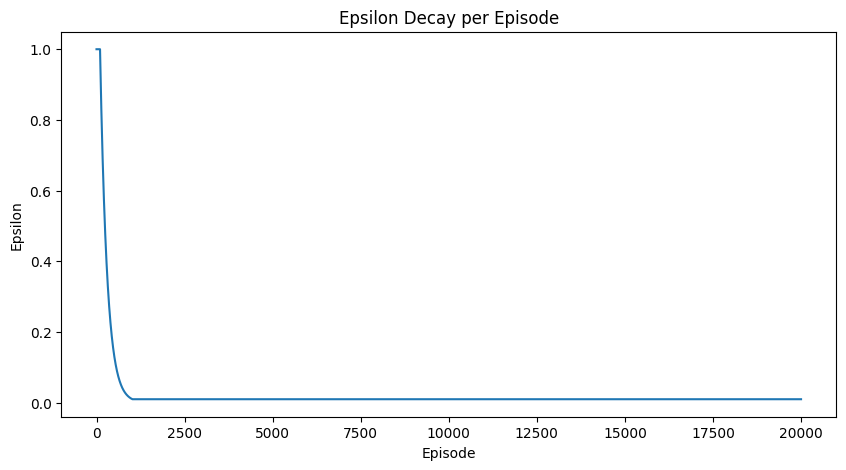

In [13]:
# set the parameters

sequence_length = 1
init_epsilon = 1
M = 20000
G = 100
min_epsilon = 0.01
decay = 0.995
T = 500
N = 10000
batch_size = 64
gamma = 0.99
C = 100

# set the number of test episodes and seeds for each episode

num_test_episodes = 100
epsiode_seeds = [random.randint(0, 2**32 - 1) for _ in range(num_test_episodes)]

# evaluate a random untrained model

Q_untrained = Net(sequence_length)
Q_untrained.eval()

with torch.no_grad():
    untrained_total_rewards = []
    environment = gym.make("CartPole-v1", render_mode = None)

    for i in range(num_test_episodes):
        observation, info = environment.reset(seed = epsiode_seeds[i])
        s = [observation for _ in range(sequence_length)]
        total_reward = 0

        while True:
            action = torch.argmax(Q_untrained(preprocess(s))).item()
            observation, reward, terminated, truncated, info = environment.step(action)
            s.pop(0)
            s.append(observation)
            total_reward += reward

            if terminated or truncated:
                break
        
        untrained_total_rewards.append(total_reward)
    
    environment.close()

print(f"Untrained Total Rewards averaged out to {np.mean(untrained_total_rewards)} with a standard deviation of {np.std(untrained_total_rewards, ddof=1)}")

# begin the training procedure

training_start = time()

weights, y_reward, y_decay = deep_Q_learning(sequence_length, init_epsilon, M, G, min_epsilon, decay, T, N, batch_size, gamma, C, epsiode_seeds)

training_end = time()

print(f"Training took {(training_end - training_start) / 60} minutes")

# save the weights

path = r"C:\Users\jason\OneDrive\Desktop\MY STUFF AS I WANT IT\Python\CSE 546 Assignment 2"
path_weights = os.path.join(path, "a2_part_2_dqn_cartpole_Jason_Freitas_Kim_Kyudong.h5")

with h5py.File(path_weights, "w") as h5f:
    for name, param in weights.items():
        h5f.create_dataset(name, data=param.cpu().numpy())

# evaluate the trained model

Q_trained = Net(sequence_length)
Q_trained.eval()

with h5py.File(path_weights, "r") as h5f:
    for name, param in Q_trained.named_parameters():
        param.data.copy_(torch.tensor(h5f[name][:]))

with torch.no_grad():
    trained_total_rewards = []
    environment = gym.make("CartPole-v1", render_mode = None)

    for i in range(num_test_episodes):
        observation, info = environment.reset(seed = epsiode_seeds[i])
        s = [observation for _ in range(sequence_length)]
        total_reward = 0

        while True:
            action = torch.argmax(Q_trained(preprocess(s))).item()
            observation, reward, terminated, truncated, info = environment.step(action)
            s.pop(0)
            s.append(observation)
            total_reward += reward

            if terminated or truncated:
                break
        
        trained_total_rewards.append(total_reward)
    
    environment.close()

print(f"Trained Total Rewards averaged out to {np.mean(trained_total_rewards)} with a standard deviation of {np.std(trained_total_rewards, ddof=1)}")

# plot the reward and epsilon

plt.figure(figsize=(10, 5))
plt.plot(y_reward)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Total Reward per Episode")

plt.figure(figsize=(10, 5))
plt.plot(y_decay)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay per Episode")

Text(0.5, 1.0, 'Total Reward per Episode After Training')

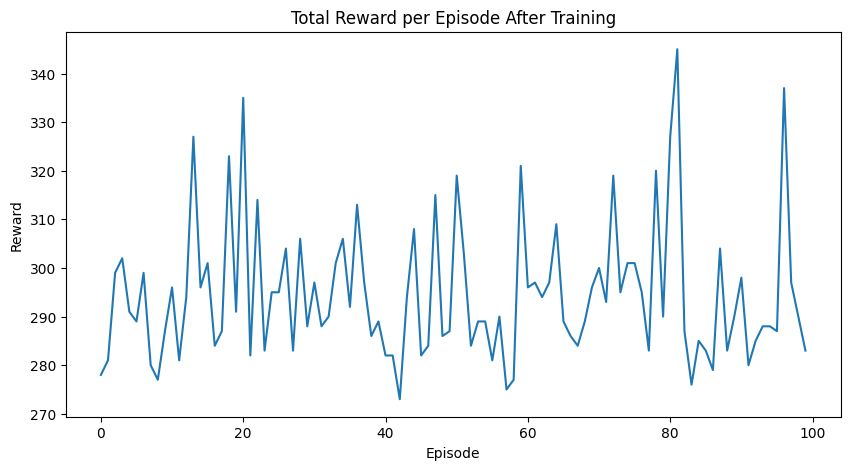

In [16]:
# plot the testing rewards per epsiode

plt.figure(figsize=(10, 5))
plt.plot(trained_total_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Total Reward per Episode After Training")